In [1]:
# -*- coding:utf-8 -*-
import json
import requests
import csv,re,os,math,glob
from lxml import etree
from datetime import date,datetime
import pandas as pd
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
import hashlib #check md5sum of rawdata files
####新项目，近5年分红去高去低*回购率排名，同时要求分红逆序数（假）不能超过6

In [2]:
#Save_interest_rate

In [3]:
def save_interest_rate(data):
    
    # 1. 创建文件对象
    f = open('CB_interest_rate.csv', 'w', encoding='utf-8', newline='')
    # 2. 基于文件对象构建 csv写入对象
    csv_writer = csv.writer(f)
    # 3. 构建列表头
    csv_writer.writerow(["id","iry1", "iry2", "iry3", "iry4", "iry5", "iry6"])
    
    count = 0
    for item in data:
        count +=1
        if (count %10 == 0):
            print("processing "+str(count)+" items")
        try:
            interest = get_interest_rate(item['id'])
            interest = [item['id']]+interest
            csv_writer.writerow(interest)
        except Exception as e:
            print("Oops!", e.__class__, "occurred.")
            print("The error happed at "+item['id'])
    # 5. 关闭文件
    print("Finished processing "+str(count)+" items")
    f.close()


In [4]:
#append_interest_rate

In [5]:
def append_interest_rate(item):
    
    # 1. 创建文件对象
    interest_dict = get_interest_dict('CB_interest_rate.csv')
    if item['id'] in interest_dict:
        return
    f = open('CB_interest_rate.csv', 'a', encoding='utf-8', newline='')
    # 2. 基于文件对象构建 csv写入对象
    csv_writer = csv.writer(f)
    
    

    try:
        interest = get_interest_rate(item['id'])
        interest = [item['id']]+interest
        csv_writer.writerow(interest)
        print("Finished appending new CB "+ item['name']+" into interest rate files")
    except Exception as e:
        print("Oops!", e.__class__, "occurred.")
        print("The error happed at "+item['id'])
    
    # 5. 关闭文件
    
    f.close()


In [6]:
#get_interest_rate

In [7]:
def get_interest_rate(id):
    years = 6
    detials_url = 'https://www.jisilu.cn/data/convert_bond_detail/'+id
    detials_response = requests.get(detials_url)
    html = detials_response.content.decode("utf-8")
    html = etree.HTML(html)
    interest_text = html.xpath('.//td[@id="cpn_desc"]/text()')
    if(not interest_text[0].find('%')):
        print(" not in interest test %s %s"%(id,interest_text))
        pattern = re.compile(r'(?<!\d|\.)\d+(?:\.\d+)?')  #get proper format number
    else:
        pattern = re.compile(r'(?<!\d|\.)\d+(?:\.\d+)?\s?%')  #get proper format number
    interest = pattern.findall(interest_text[0])
    if(len(interest) <= 1):
        print("%s fixed interest rate %s"%(id, interest_text[0]))
        interest = interest*years
    elif(len(interest)<5):
        print("%s number of interest rate between 2-4 %s"%(id, interest_text[0]))
        print("You may need to check manually")
    elif(len(interest)>6):
        print("%s number of interest rate greater than 6 %s"%(id, interest_text[0]))
        print("You may need to check manually")
    interest = [rate.strip("%") for rate in interest]
    return interest

In [8]:
# get interest dict

In [9]:
def get_interest_dict(file):
    interest_dict = dict()
    with open(file) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        for row in csv_reader:
            if line_count == 0:
                #skip header
                line_count += 1
            else:
                interest_dict[row[0]] = row[1:]
                line_count += 1
        print(f'Processed {line_count} lines.')
    return interest_dict


In [10]:
# buy or sell cb

In [11]:
def buy_sell_db(db_df,file,show_price=False):
    db_df = db_df[(db_df['force_redeem'] != 'Y')]
    total_number = len(db_df)
    quartile = np.percentile(db_df['db_low'],25) ##first quartile
    keep_number = int(total_number*0.1)  ##10th percentile
    buy_number  = int(total_number*0.05) ##5th percentile
    add_number = int(total_number*0.02)  ##2th percentile
    
    keep_dict = {i:db_df['name'][i] for i in db_df[0:keep_number].index}
    buy_dict = {i:db_df['name'][i] for i in db_df[0:buy_number].index}
    add_dict = {i:db_df['name'][i] for i in db_df[0:add_number].index}
    sell_count = 0
    holding_dict = dict()
    
    ##sell
    my_list = []
    with open(file) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            cb_id,cb_name,_,_ = row
            if cb_id not in db_df.index:
                print("%s %s %s"%(cb_id,cb_name,'not in lists'))
                continue
            holding_dict[cb_id] = cb_name
            price = db_df.loc[cb_id]['price']
            db_low = db_df.loc[cb_id]['db_low']
            item = {'id':cb_id,'name':cb_name,'price':price,'db_low':db_low}
            my_list.append(item)
            if cb_id not in keep_dict.keys():
                sell = "Sell"
                if(db_low>quartile):
                    sell = "Strong Sell"
                if(show_price):
                    print("%s %s %s %s %.3f"%(sell,cb_id,cb_name,price,db_low))
                else:
                    print("%s %s %s"%(sell,cb_id,cb_name))
                sell_count += 1
    if(sell_count==0):
        print('No CB to sell')
        
    ##buy
    print()
    for cb_id,cb_name in add_dict.items():
        price = db_df.loc[cb_id]['price']
        db_low = db_df.loc[cb_id]['db_low']
        if(show_price):
            print("Add  %s %s %s %.3f"%(cb_id,cb_name,price,db_low))
        else:
            print("Add  %s %s"%(cb_id,cb_name))
    print()
    for cb_id in buy_dict.keys():
        if cb_id not in holding_dict.keys():
            price = db_df.loc[cb_id]['price']
            db_low = db_df.loc[cb_id]['db_low']
            cb_name = keep_dict[cb_id]
            if(show_price):
                print("Buy  %s %s %s %.3f"%(cb_id,cb_name,price,db_low))
            else:
                print("Buy  %s %s"%(cb_id,cb_name))
    
    my_df = pd.DataFrame(my_list)
    my_df = my_df.set_index(['id'])
    my_df = my_df.sort_values('db_low',ascending=True)
    return my_df,buy_dict
    

In [12]:
#buy sell low

In [13]:
def buy_sell_low(lp_df,db_buy_dict,file,show_price=False):
    total_number = len(lp_df)
    quartile = np.percentile(lp_df['lower_deviation'],25) ##first quartile
    keep_number = int(total_number*0.1)  ##10th percentile
    buy_number  = int(total_number*0.05) ##5th percentile
    add_number = int(total_number*0.02)  ##2th percentile
    
    keep_dict = {i:lp_df['name'][i] for i in lp_df[0:keep_number].index}
    buy_dict = {i:lp_df['name'][i] for i in lp_df[0:buy_number].index}
    add_dict = {i:lp_df['name'][i] for i in lp_df[0:add_number].index}
    sell_count = 0
    holding_dict = dict()
    
    ##sell
    my_list = []
    with open(file) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            cb_id,cb_name,_,_ = row
            if cb_id not in lp_df.index:
                print("%s %s %s"%(cb_id,cb_name,'not in lists'))
                sell_count += 1
                continue
            holding_dict[cb_id] = cb_name
            price = lp_df.loc[cb_id]['price']
            db_low  = lp_df.loc[cb_id]['db_low']
            premium = lp_df.loc[cb_id]['premium']
            lower_deviation = lp_df.loc[cb_id]['lower_deviation']
            fit_price = lp_df.loc[cb_id]['fit_price']
            low_fit_price = lp_df.loc[cb_id]['low_fit_price']
            upper_fit_price = lp_df.loc[cb_id]['upper_fit_price']
            item = {'id':cb_id,'name':cb_name,'price':price,'db_low':db_low,'premium':premium,
                    'lower_deviation':lower_deviation}
            my_list.append(item)
            if cb_id not in keep_dict.keys() or price>fit_price:
                sell = "Sell"
                if(lower_deviation>quartile or price>upper_fit_price):
                    sell = "Strong Sell"
                if(show_price):
                    print("%s %s %s %s %.3f %.3f %.3f"
                          %(sell,cb_id,cb_name,price,db_low,premium,lower_deviation))
                else:
                    print("%s %s %s"%(sell,cb_id,cb_name))
                sell_count += 1
    if(sell_count==0):
        print('No CB to sell')
        
    ##buy
    print()
    for cb_id,cb_name in add_dict.items():
        price = lp_df.loc[cb_id]['price']
        db_low  = lp_df.loc[cb_id]['db_low']
        premium = lp_df.loc[cb_id]['premium']
        lower_deviation = lp_df.loc[cb_id]['lower_deviation']
        low_fit_price = lp_df.loc[cb_id]['low_fit_price']
        if price>=low_fit_price:
            continue
        if(show_price):
            print("Add  %s %s %s %.3f %.3f %.3f"
                  %(cb_id,cb_name,price,db_low,premium,lower_deviation))
        else:
            print("Add  %s %s"%(cb_id,cb_name))
    print()
    for cb_id,cb_name in buy_dict.items():
        price = lp_df.loc[cb_id]['price']
        db_low  = lp_df.loc[cb_id]['db_low']
        premium = lp_df.loc[cb_id]['premium']
        lower_deviation = lp_df.loc[cb_id]['lower_deviation']
        low_fit_price = lp_df.loc[cb_id]['low_fit_price']
        if cb_id in db_buy_dict.keys():
            print("Strong Buy %s %s %s %.3f %.3f %.3f"
                  %(cb_id,cb_name,price,db_low,premium,lower_deviation))
        elif cb_id not in holding_dict.keys():
            if price>=low_fit_price:
                continue
            
            if(show_price):
                print("Buy %s %s %s %.3f %.3f %.3f"
                  %(cb_id,cb_name,price,db_low,premium,lower_deviation))
            else:
                print("Buy  %s %s"%(cb_id,cb_name))
    
    #my_df = pd.DataFrame(my_list)
    #my_df = my_df.set_index(['id'])
    #my_df = my_df.sort_values('premium',ascending=True)
    #return my_df
    

In [14]:
# read historical data

In [15]:
def read_historical_data(file):
    history_list = []
    with open(file) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        next(csv_reader, None)  # skip the headers
        for row in csv_reader:
            history_list.append(row)
    return history_list

In [16]:
# get data

In [17]:
def get_dat():
    # Fill in your details here to be posted to the login form.
    payload = {
        'user_name': 'a39856ed4377d1b92cffb0677febf5b8',
        'password': 'ca5572b5ffe8c33746727709bc7d6c6f'
    }
    headers = {
        "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.114 Safari/537.36",
        #"User-agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/51.0.2704.106 Safari/537.36 OPR/38.0.2220.41",
        "Cookie": "kbzw__Session=l313fggdcjpnd7eineqilm6lf4; kbz_newcookie=1; kbzw_r_uname=ijayden; Hm_lvt_164fe01b1433a19b507595a43bf58262=1627073048,1627079966,1627115858,1627117055; Hm_lpvt_164fe01b1433a19b507595a43bf58262=1627118717"
    }
    loginUrl="https://www.jisilu.cn/account/ajax/login_process/"
    r = requests.post(loginUrl,data=payload)

    newUrl ="https://www.jisilu.cn/data/cbnew/cb_list/?___jsl=LST___t=1584777951900"
    #最简单的爬虫请求.也可以加上headers字段，防止部分网址的反爬虫机制
    response = requests.get(newUrl,cookies=r.cookies)
    data = response.content.decode("utf-8")
    dat = json.loads(data)

    # 所有数据
    lst_data = []
    raw_data = []
    count = 0
    
    for one in dat['rows']:
        # 每一条数据
        lst_dat = dict()
        # 转债id
        id = one["id"]
        dat_cell = one["cell"]
        # 是否赎回
        is_force_redeem = dat_cell['redeem_flag']
        is_list = dat_cell['price_tips']
        raw_data.append(dat_cell)
        if is_list != "待上市":
            
            count += 1
            if (count %100 == 0):
                print("processing "+str(count)+" items")
            
            # 现价
            price = dat_cell['price']
            # stock id
            stock_id = dat_cell['stock_id']
            stock_id = stock_id.replace("sh", "ss")
            stock_id = stock_id[2:]+"."+stock_id[0:2]
            # stock name
            stock_nm = dat_cell['stock_nm']
            # 溢价率
            premium_rt = dat_cell['premium_rt']
            # 评级
            rating_cd = dat_cell['rating_cd']
            
            
            # next put date
            next_put_dt = dat_cell['next_put_dt']
            # put price
            put_price   = dat_cell['put_price']
            # 回售触发价
            put_convert_price = dat_cell['put_convert_price']
            
            
            # maturity date
            maturity_dt = dat_cell['maturity_dt']
            # redeem price
            redeem_price = dat_cell['redeem_price']
            
            # 强赎触发价
            redeem_dt = dat_cell['redeem_dt']
            force_redeem_price = dat_cell['force_redeem_price']
            # 剩余时间
            last_time = dat_cell['year_left']
            #pb
            pb = dat_cell['pb']


            #lst_dat.append(id)
            lst_dat['id'] = id
            lst_dat['name'] = dat_cell['bond_nm'] # 转债名称
            lst_dat['stock_id'] = stock_id
            lst_dat['stock_name'] = stock_nm
            lst_dat['price'] = float(price)
            lst_dat['convert_value'] = float(dat_cell['convert_value'])
            lst_dat['premium_rt'] = premium_rt
            lst_dat['rating_cd'] = rating_cd
            lst_dat['pb']  = pb
            lst_dat['convert_amt_ratio'] = dat_cell['convert_amt_ratio']
            lst_dat['convert_amt_ratio2'] = dat_cell['convert_amt_ratio2']
            
            
            
            lst_dat['next_put_dt'] = next_put_dt
            lst_dat['put_price'] = put_price
            lst_dat['put_convert_price'] = put_convert_price
            
            lst_dat['maturity_dt'] = maturity_dt
            lst_dat['redeem_price'] = redeem_price
            lst_dat['last_time'] = last_time
            lst_dat['force_redeem'] = is_force_redeem
            
            lst_dat['redeem_dt']  = redeem_dt
            lst_dat['force_redeem_price'] = force_redeem_price
            
            lst_dat['redeem_price_ratio']  =  dat_cell['redeem_price_ratio']
            lst_dat['redeem_count_days'] =  dat_cell['redeem_count_days']
            lst_dat['redeem_real_days']  =  dat_cell['redeem_real_days']
            
            
            
  
            lst_data.append(lst_dat)
           
            
        else:
            continue
    print("Finished processing "+str(count)+" items")
    
    return lst_data,raw_data

In [18]:
#put arbitrage

In [19]:
def put_arbitrage(data):
    data_copy = deepcopy(data)
    put_data = []
    count = 0
    for item in data_copy:
        price       = item['price']
        put_price   = item['put_price']

        
        if(put_price is None):
            continue
            
        price = float(price)
        put_price = float(put_price)
            
        if(price>put_price+5.0): ###To Save Time, the maximun interest could not over 10
            continue
            
        next_put_dt = item['next_put_dt']
        next_put_dt = datetime.strptime(next_put_dt,'%Y-%m-%d').date()
        maturity_dt = item['maturity_dt']
        maturity_dt = datetime.strptime(maturity_dt,'%Y-%m-%d').date()
        today = date.today()
        
        
        days_to_maturity = maturity_dt-today
        years_to_maturity = days_to_maturity.days/365
        days_to_put  = next_put_dt-today
        years_to_put  = days_to_put.days/365
        
        put_to_maturity = round(years_to_maturity-years_to_put)
        #print(put_to_maturity)
        
        
        if item['id'] in interest_dict.keys():
            interest = interest_dict[item['id']]
        else:
            append_interest_rate(item)
            interest = get_interest_rate(item['id'])
        
        
        total_interest = 0
        for i in range(3,math.ceil(years_to_put)+put_to_maturity+1):
            #print(i)
            #print(interest)
            #print(item['id'])
            total_interest += float(interest[-i])
        
        
    
        
        actual_put_price = put_price*(1+total_interest*0.008)  ####20%的所得税
        
        
        if(price<actual_put_price):
            year_diff = years_to_put + 38/365  #进入回售期后的38日
            profit_rate = actual_put_price/price
            CAGR  = profit_rate ** (1/year_diff)-1
            item['actual_put_price'] = actual_put_price
            item['CAGR'] = CAGR
            item['last_to_put'] = year_diff
            put_data.append(item)
        
        count += 1
        if (count %100 == 0):
            print("processing"+str(count)+" items")
    
    print("Finished processing "+str(count)+" items")
    df = pd.DataFrame(put_data)
    df = df.set_index(['id'])
    df = df.sort_values('CAGR',ascending=False)
    return df
          

In [20]:
# redeem arbitrage

In [21]:
def redeem_arbitrage(data):
    put_data = []
    data_copy = deepcopy(data)
    for item in data_copy:
        price       = item['price']
        redeem_price   = item['redeem_price']

        
        if(redeem_price is None):
            continue
            
        price = float(price)
        redeem_price = float(redeem_price)
            

        
        maturity_dt = item['maturity_dt']
        maturity_dt = datetime.strptime(maturity_dt,'%Y-%m-%d').date()
        today = date.today()
        
        days_to_maturity = maturity_dt-today
        years_to_maturity = days_to_maturity.days/365
        
        
        if item['id'] in interest_dict.keys():
            interest = interest_dict[item['id']]
        else:
            append_interest_rate(item)
            interest = get_interest_rate(item['id'])
            
        total_interest = 0
        for i in range(2,math.ceil(years_to_maturity)):
            total_interest += float(interest[-i])
            
        actual_price = redeem_price*(1+total_interest*0.008)
        
        if(price<actual_price):
            year_diff = years_to_maturity
            profit_rate = actual_price/price
            CAGR  = profit_rate ** (1/year_diff)-1
            item['CAGR'] = CAGR
            put_data.append(item)
    df = pd.DataFrame(put_data)
    df = df.set_index(['id'])
    df = df.sort_values('CAGR',ascending=False)
    return df
          

In [22]:
# double low arbitarge

In [23]:
def double_low_arbitrage(data,redeem_df,put_df):
    db_data = []
    DISCOUNT = 1  ###convert amt ratio discount 
    data_copy = deepcopy(data)
    
    redeem_dict = redeem_df.to_dict('index')
    put_dict = put_df.to_dict('index')
    
    stock_amt_ratio_dict = dict()
    for item in data_copy:
        id = item['id']
        force_redeem = item['force_redeem']
        if(force_redeem == "Y"):
            continue
        stock_id = item['stock_id']
        convert_amt_ratio = item['convert_amt_ratio2'] #####ratio is float ratio, ratio is total ratio
        convert_value = float(item['convert_value'])
        
        convert_amt_ratio = float(convert_amt_ratio.strip('%'))/100
        #####Adjust convert amt ratio
        convert_amt_ratio *= convert_value/100  ###adjust the convert amt ratio to the percentage shares
        
        if stock_id not in stock_amt_ratio_dict.keys():
            stock_amt_ratio_dict[stock_id] = convert_amt_ratio
        else:
            stock_amt_ratio_dict[stock_id] += convert_amt_ratio
        
    
    for item in data_copy:
        id = item['id']
        stock_id = item['stock_id']
        price       = item['price']
        premium_rt = item['premium_rt']
        convert_value = float(item['convert_value'])
        force_redeem = item['force_redeem']
        if(force_redeem == "Y"):
            convert_amt_ratio = item['convert_amt_ratio2']#####ratio is float ratio, ratio is total ratio
            convert_amt_ratio = float(convert_amt_ratio.strip('%'))/100
            #####Adjust convert amt ratio
            convert_amt_ratio *= convert_value/100  ###adjust the convert amt ratio to the percentage shares
   
            
        else:
            convert_amt_ratio = stock_amt_ratio_dict[stock_id]
        
        price = float(price)
        premium_rt = float(premium_rt.strip('%'))/100
        #convert_amt_ratio = float(convert_amt_ratio.strip('%'))/100
        
    
 
        convert_value_discount = 1/(1+convert_amt_ratio*DISCOUNT)
        new_convert_value = convert_value*convert_value_discount
        new_premium = price/new_convert_value - 1
        #new_premium = new_premium*math.sqrt(price/100) if price>100 else new_premium
 
        
        redeem_cagr = 0
        put_cagr = 0
        if(id in redeem_dict.keys()):
            redeem_cagr = redeem_dict[id]['CAGR']
        if(id in put_dict.keys()):
            put_cagr = put_dict[id]['CAGR']
        
        item['redeem_CAGR'] = redeem_cagr
        item['put_CAGR']    = put_cagr
        item['new_convert_value'] = new_convert_value
        item['new_premium'] = new_premium
        if(redeem_cagr>put_cagr):
            db_low = price + new_premium*100 - redeem_cagr*100
        else:
            db_low = price + new_premium*100 - put_cagr*100
        
        #item['db_low'] = db_low*math.sqrt(price/100) if price>100 else db_low
        item['db_low'] = db_low
        
        db_data.append(item)
    df = pd.DataFrame(db_data)
    df = df.set_index(['id'])
    df = df.sort_values('db_low')
    return df

In [24]:
# low premium arbitrage

In [25]:
def low_premium_arbitrage(db_df): 
    import scipy.stats as stats
    db_df = db_df[(db_df['force_redeem'] != 'Y')]
    x = []
    y = []
    ids = []
    names = []
    db_lows = []
    for cb_id in db_df.index:
        name = db_df['name'][cb_id]
        value = db_df['new_convert_value'][cb_id]
        price = db_df['price'][cb_id]
        db_low = db_df['db_low'][cb_id]
        if(price>120 and price/value>1.6):
            #print("remove premium outlier %s %.3f %.3f"%(name,value,price))
            continue
        if(value>200):
            #print("remove price over 200 %s %.3f %.3f"%(name,value,price))
            continue
        x.append(value)
        y.append(price)
        ids.append(cb_id)
        names.append(name)
        db_lows.append(db_low)

    x = np.array(x)
    y = np.array(y)
    ids = np.array(ids)
    names = np.array(names)
    db_lows = np.array(db_lows)
    indexes = np.argsort(x)
    x = x[indexes]
    y = y[indexes]
    ids = ids[indexes]
    names = names[indexes]
    db_lows = db_lows[indexes]

    coef = np.polyfit(x, y, 2)
    save_coef_data(coef,'coef_history.csv')
    poly = np.poly1d(coef)

    n = len(x)
    yfit = poly(x)
    resid = y - yfit
    s_err = np.sqrt(np.sum(resid**2)/(n - 2))  # standard deviation of the error (residuals)
    # Confidence interval for the linear fit:
    t = stats.t.ppf(0.8, n - 2)
    ci = t * s_err * np.sqrt(1/n + (x - np.mean(x))**2/np.sum((x-np.mean(x))**2))
    # Prediction interval for the linear fit:
    pi = t * s_err * np.sqrt(1 + 1/n + (x - np.mean(x))**2/np.sum((x-np.mean(x))**2))

    convert_value_limit = (1-coef[1])/2/coef[0]
    price_limit = poly(convert_value_limit)
    #xext = np.linspace(convert_value_limit,max(x))
    #yext = xext+price_limit-convert_value_limit
    ext_index = np.argmax(x>=convert_value_limit)
    xext = x[ext_index:]
    yext = xext+price_limit-convert_value_limit
    piext = pi[ext_index:]

    lp_data = []
    for i,cb_id in enumerate(ids):
        value = x[i]
        price = y[i]
        cb_name = names[i]
        db_low  = db_lows[i]

        premium = (price/value-1)*100
        
        if(price<price_limit):
            lower_deviation = price/(yfit[i]-pi[i])*100-100
            item = {'id':cb_id,'name':cb_name,'value':value,'price':price,'premium':premium,
                    'db_low':db_low, 'lower_deviation':lower_deviation,
                    'fit_price':yfit[i],'low_fit_price':yfit[i]-pi[i],
                    'upper_fit_price':yfit[i]+pi[i]}
        else:
            intercept = price_limit - convert_value_limit
            lower_deviation = price/(x[i]+intercept-pi[i])*100-100
            item = {'id':cb_id,'name':cb_name,'value':value,'price':price,'premium':premium,
                    'db_low':db_low, 'lower_deviation':lower_deviation,
                    'fit_price':x[i]+intercept,'low_fit_price':x[i]+intercept-pi[i],
                    'upper_fit_price':x[i]+intercept+pi[i]}
        lp_data.append(item)
        plt.rcParams["figure.figsize"] = (18,10)
        if cb_id in my_df.index:
        #if price<yfit[i]-pi[i]:
            plt.scatter(value, price, marker='o', s=5,color='maroon')
            plt.text(value+.03, price+.03, cb_id, fontsize=8)
        else:
            plt.scatter(value, price, marker='o', s=5,color='darkgreen')
            



    lp_df = pd.DataFrame(lp_data)
    lp_df = lp_df.set_index(['id'])
    lp_df = lp_df.sort_values('lower_deviation')
    plt.plot(x,yfit,color='red')
    plt.plot(xext,yext,color='skyblue')
    plt.fill_between(x, yfit-ci, yfit+ci,color=[1, 0, 0, 0.15])
    plt.fill_between(x, yfit-pi, yfit+pi,color=[1, 0, 0, 0.1])
    plt.fill_between(xext, yext-piext, yext,color='skyblue',alpha=0.1)
    #plt.plot(x,yfit)
    mse = np.square(resid).mean()
    print("mse=%.3f"%mse)
    plt.show()
    plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
    return lp_df

In [26]:
# save historical data

In [27]:
def save_historical_data(df,col,file):
    s = df[col]
    min_db = s.min()
    max_db = s.max()
    mean_db = s.mean()
    median_db = s.median()
    pt2_db = np.percentile(s,2)
    pt5_db = np.percentile(s,5)
    pt10_db = np.percentile(s,10)
    quartile_db = np.percentile(s,25)
    today = date.today().strftime("%Y-%m-%d")
    history_list = read_historical_data(file)
    if(today not in history_list[-1]):
        f = open(file, 'a', encoding='utf-8', newline='')
        csv_writer = csv.writer(f)
        #csv_writer.writerow(["date","min", "quartile", "median", "mean", "max"])
        today_item = [today,str(min_db),str(pt2_db),str(pt5_db),str(pt10_db),str(quartile_db),str(median_db),str(mean_db),str(max_db)]
        if(today_item != history_list[-1]):
            csv_writer.writerow(today_item)
        f.close()
    else:
        f = open(file, 'w', encoding='utf-8', newline='')
        csv_writer = csv.writer(f)
        csv_writer.writerow(["date","min", "pt2","pt5","pt10","quartile", "median", "mean", "max"])
        for i in range(len(history_list)-1):
            csv_writer.writerow(history_list[i])
        csv_writer.writerow([today,min_db,pt2_db,pt5_db,pt10_db,quartile_db,median_db,mean_db,max_db])
        f.close()
    
    print('today quartile '+str(quartile_db))
    
    

In [28]:
#save coeffient 

In [29]:
def save_coef_data(coef,file):
    today = date.today().strftime("%Y-%m-%d")
    history_list = read_historical_data(file)
    if(today not in history_list[-1]):
        f = open(file, 'a', encoding='utf-8', newline='')
        csv_writer = csv.writer(f)
        today_item = [today,str(coef[0]),str(coef[1]),str(coef[2])]
        if(today_item != history_list[-1]):
            csv_writer.writerow(today_item)
        f.close()
    else:
        f = open(file, 'w', encoding='utf-8', newline='')
        csv_writer = csv.writer(f)
        csv_writer.writerow(["date","a", "b","c"])
        for i in range(len(history_list)-1):
            csv_writer.writerow(history_list[i])
        csv_writer.writerow([today,coef[0],coef[1],coef[2]])
        f.close()
    
    print('today coef '+str(coef))
    

In [30]:
# save raw data

In [31]:
def save_raw_data():
    import warnings
    files = glob.glob("raw_data/CB_list*csv")
    files = np.array(sorted(files))
    md5_old = hashlib.md5(open(files[-1],'rb').read()).hexdigest()
    md5_new = hashlib.md5(open('CB_list.csv','rb').read()).hexdigest()
    if(md5_old != md5_new):
        today = date.today().strftime("%Y-%m-%d")
        new_file = 'raw_data/CB_list.'+today+'.csv'
        return_value = os.system("cp CB_list.csv "+new_file)
        if return_value == 0:
            print("successfully save raw CB data")
        else:
            warnings.warn("problems when copying CB_list files")
    else:
        print("No need to update raw CB list")

In [32]:
# plot history

In [33]:
def plot_history(file):
    import datetime as dt
    import matplotlib.dates as mdates
    his = pd.read_csv(file, sep=',')
    his['date'] = pd.to_datetime(his['date'], format='%Y-%m-%d')
    
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))

    plt.plot( 'date', 'min', data=his, marker='o', markerfacecolor='blue', markersize=6, color='skyblue', linewidth=2)
    plt.plot( 'date', 'pt2', data=his, marker='o', markerfacecolor='sienna', markersize=6, color='peru', linewidth=2)
    plt.plot( 'date', 'pt5', data=his, marker='o', markerfacecolor='tomato', markersize=6, color='salmon', linewidth=2)
    plt.plot( 'date', 'pt10', data=his, marker='o', markerfacecolor='gold', markersize=6, color='goldenrod', linewidth=2)
    plt.plot( 'date', 'quartile', data=his, marker='o', markerfacecolor='olivedrab', markersize=6, color='olive', linewidth=2)
    plt.plot( 'date', 'median', data=his, marker='o', markerfacecolor='darkorange', markersize=6, color='orange', linewidth=2)
    #plt.plot( 'date', 'mean', data=his, marker='v', markerfacecolor='tomato', markersize=6, color='salmon', linewidth=2)
    # show legend
    plt.gcf().autofmt_xdate()
    plt.legend(loc='center left',bbox_to_anchor=(1, 0.5))
    # show graph
    plt.show()

In [34]:
data,raw_data = get_dat()
pd.DataFrame.from_dict(raw_data).to_csv(r'CB_list.csv',index=False)
save_raw_data()

processing 100 items
processing 200 items
processing 300 items
Finished processing 380 items
successfully save raw CB data


In [35]:
interest_dict = get_interest_dict('CB_interest_rate.csv')

Processed 406 lines.


In [36]:
redeem_df = redeem_arbitrage(data)

In [37]:
put_df = put_arbitrage(data)

Finished processing 50 items


110033 国贸转债 not in lists
Sell 110072 广汇转债 95.98 150.477
Strong Sell 127034 绿茵转债 102.518 164.406
Strong Sell 128062 亚药转债 92.005 389.435
Sell 128096 奥瑞转债 144.913 150.610
Strong Sell 128127 文科转债 96.38 184.360
Sell 128133 奇正转债 109.279 148.776

Add  128100 搜特转债 99.157 124.831
Add  113009 广汽转债 125.85 129.465
Add  132018 G三峡EB1 126.05 130.201
Add  110070 凌钢转债 115.16 133.768
Add  113607 伟20转债 127.47 134.042
Add  113591 胜达转债 120.99 135.683
Add  128085 鸿达转债 133.384 136.286

Buy  113009 广汽转债 125.85 129.465
Buy  110070 凌钢转债 115.16 133.768
Buy  113591 胜达转债 120.99 135.683
Buy  113541 荣晟转债 128.93 137.195
Buy  123080 海波转债 120.05 139.799
Buy  113565 宏辉转债 120.51 140.929
Buy  127042 嘉美转债 126.2 141.393
Buy  128121 宏川转债 125.477 141.394
Buy  128040 华通转债 116.078 141.519
Buy  113030 东风转债 119.96 141.808
Buy  128094 星帅转债 132.038 142.442
today coef [ 3.27529915e-03 -1.47694256e-02  9.59097742e+01]
mse=53.110


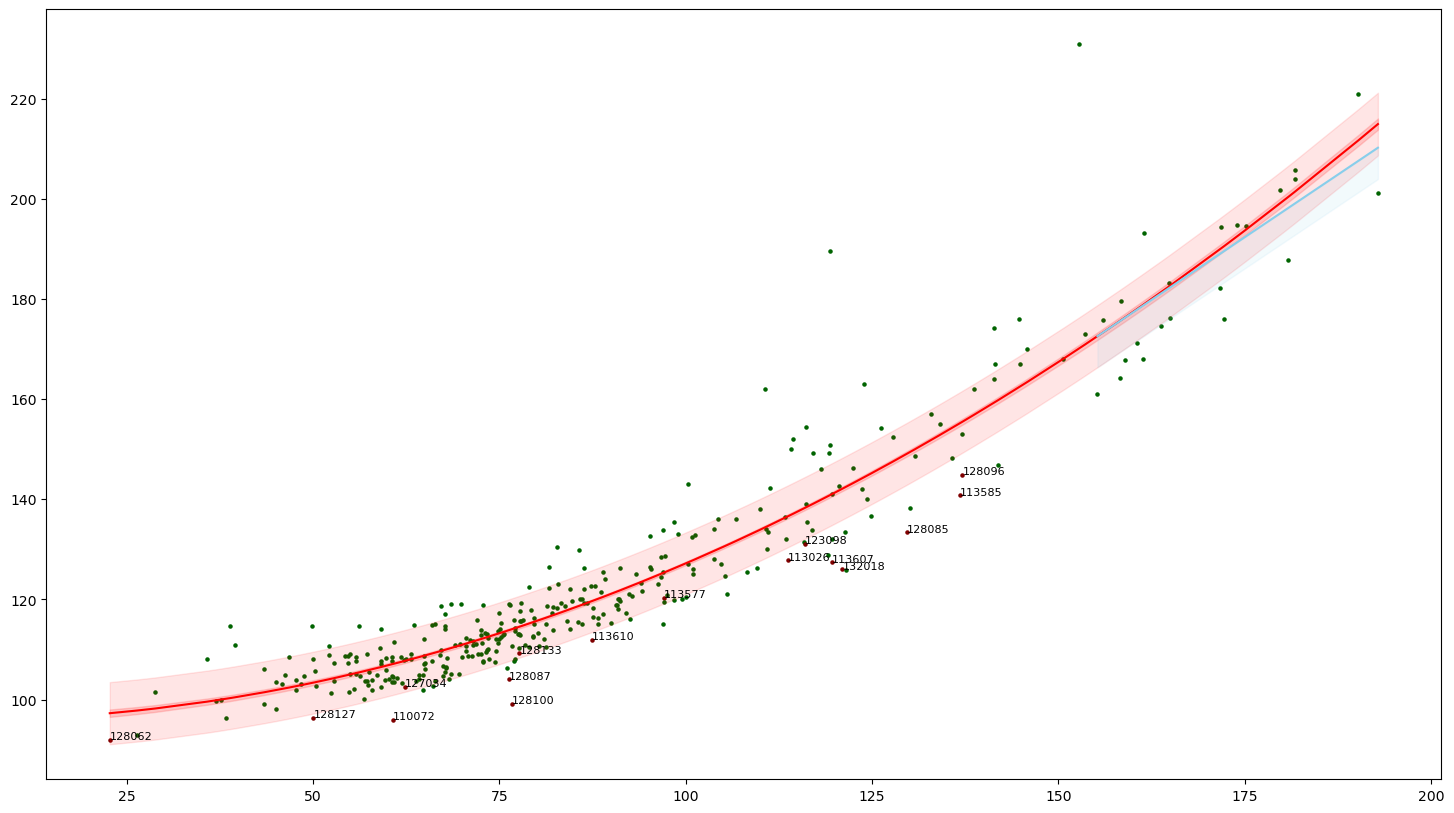

In [38]:
db_df = double_low_arbitrage(data,redeem_df,put_df)
my_df,db_buy_dict = buy_sell_db(db_df,'mycb_list.csv',show_price=True)
lp_df = low_premium_arbitrage(db_df)

In [39]:
lp_df[(lp_df['value'] < 200) & (lp_df['value'] > 180)]

,name,value,price,premium,db_low,lower_deviation,fit_price,low_fit_price,upper_fit_price
id,,,,,,,,,
123083,朗新转债,180.795777,187.689,3.812712,191.501712,-2.177386,198.105328,191.866678,204.343978
128128,齐翔转2,192.869244,201.200,4.319380,205.519380,-1.334183,210.178794,203.920676,216.436913
127030,盛虹转债,181.764019,203.850,12.150909,216.000909,5.712991,199.073569,192.833443,205.313694
123084,高澜转债,181.738773,205.810,13.244959,219.054959,6.743365,199.048323,192.808236,205.288410
128017,金禾转债,190.244688,221.000,16.166187,237.166187,9.786089,207.554239,201.300549,213.807928


In [40]:
buy_sell_low(lp_df,db_buy_dict,'mycb_list.csv',show_price=True)

110033 国贸转债 not in lists
Sell 113577 春秋转债 120.3 144.274 23.974 0.967
Sell 127034 绿茵转债 102.518 164.406 64.486 0.964
Sell 128062 亚药转债 92.005 389.435 304.963 1.036
Sell 128133 奇正转债 109.279 148.776 40.696 0.855

Add  128100 搜特转债 99.157 124.831 29.299 -8.078
Add  113009 广汽转债 125.85 129.465 3.615 -7.638
Add  132018 G三峡EB1 126.05 130.201 4.151 -7.261
Add  128085 鸿达转债 133.384 136.286 2.902 -6.623
Add  113585 寿仙转债 140.78 143.738 2.958 -5.479
Add  113607 伟20转债 127.47 134.042 6.572 -5.455

Strong Buy 128100 搜特转债 99.157 124.831 29.299 -8.078
Strong Buy 113009 广汽转债 125.85 129.465 3.615 -7.638
Strong Buy 132018 G三峡EB1 126.05 130.201 4.151 -7.261
Strong Buy 128085 鸿达转债 133.384 136.286 2.902 -6.623
Strong Buy 113607 伟20转债 127.47 134.042 6.572 -5.455
Buy 132014 18中化EB 146.8 150.214 3.414 -4.440
Strong Buy 113541 荣晟转债 128.93 137.195 8.265 -4.087
Buy 113603 东缆转债 175.88 177.986 2.106 -4.067
Buy 123111 东财转3 138.25 144.552 6.302 -3.460
Strong Buy 128087 孚日转债 104.022 138.626 36.343 -3.396
Strong Buy 110070 凌

In [41]:
df2 = lp_df.sort_values('lower_deviation')
df2[0:30]

,name,value,price,premium,db_low,lower_deviation,fit_price,low_fit_price,upper_fit_price
id,,,,,,,,,
128100,搜特转债,76.687944,99.157,29.299334,124.831049,-8.077608,114.039305,107.870343,120.208266
113009,广汽转债,121.458954,125.850,3.615251,129.465251,-7.637689,142.434017,136.256876,148.611159
132018,G三峡EB1,121.026185,126.050,4.151015,130.201015,-7.261485,142.096699,135.919795,148.273603
128085,鸿达转债,129.622829,133.384,2.901627,136.285627,-6.623233,149.027151,142.844955,155.209347
113585,寿仙转债,136.735918,140.780,2.957586,143.737586,-5.478775,155.127585,148.940093,161.315078
113607,伟20转债,119.609724,127.470,6.571603,134.041603,-5.455276,141.001229,134.825081,147.177378
110072,广汇转债,60.733516,95.980,58.034651,150.476989,-4.894837,107.093912,100.919863,113.267961
132014,18中化EB,141.953252,146.800,3.414327,150.214327,-4.440121,159.812861,153.620957,166.004765
113541,荣晟转债,119.086884,128.930,8.265491,137.195491,-4.087293,140.600193,134.424315,146.776071


In [42]:
my_df

,name,price,db_low
id,,,
128100,搜特转债,99.157,124.831049
132018,G三峡EB1,126.050,130.201015
113607,伟20转债,127.470,134.041603
128085,鸿达转债,133.384,136.285627
128087,孚日转债,104.022,138.626193
113610,灵康转债,111.980,138.749368
113026,核能转债,127.820,140.224160
113585,寿仙转债,140.780,143.737586
123098,一品转债,131.130,144.207093


today quartile 156.94170426923057


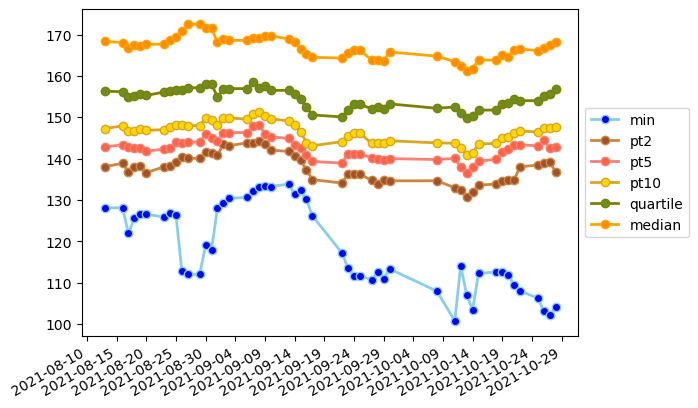

In [43]:
save_historical_data(db_df,'db_low','db_history.csv')
plot_history('db_history.csv')

today quartile 26.64658074905677


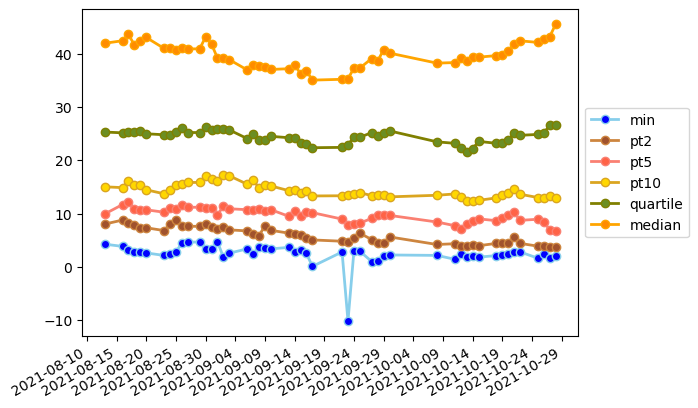

In [44]:
save_historical_data(lp_df,'premium','premium_history.csv')
plot_history('premium_history.csv')

today quartile 108.6875


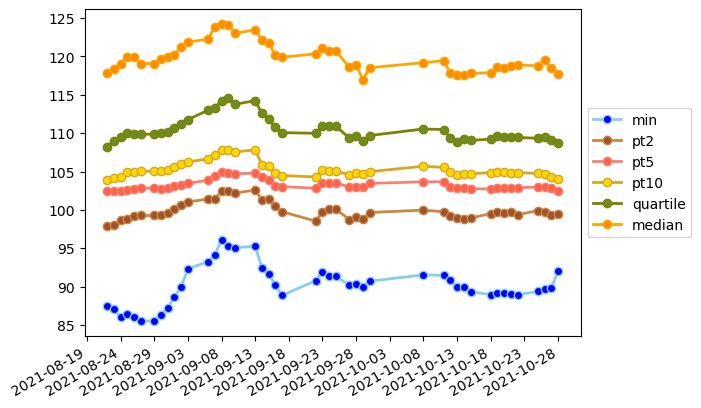

In [45]:
save_historical_data(db_df,'price','price_history.csv')
plot_history('price_history.csv')

In [46]:
print(np.percentile(db_df['db_low'],50))
print(np.percentile(db_df['price'],50))
print(np.percentile(lp_df['premium'],50))

168.1445935385902
117.775
45.52217542888768


In [47]:
lp_df[(lp_df['value'] < 30) & (lp_df['price']>70)]

,name,value,price,premium,db_low,lower_deviation,fit_price,low_fit_price,upper_fit_price
id,,,,,,,,,
128062,亚药转债,22.719344,92.005,304.963271,389.434514,1.035789,97.264829,91.061792,103.467867
113596,城地转债,26.375013,92.990,252.568551,341.585082,1.518087,97.798664,91.599441,103.997887
132011,17浙报EB,28.796139,101.490,252.443077,352.076260,10.310911,98.200408,92.003591,104.397224


In [48]:
def func(X, a, b, c, d):
    x,y = X
    return a * x ** 2 + b * x +  c * y + d 
    #return a* x + b*1/x + c*y +d

In [49]:
def three_factor_arbitrage(db_df): 
    import scipy.stats as stats
    from scipy.optimize import curve_fit
    
    redeem_default_prob = 0.5    #####probility of force redeem if conditons is satisfied
    time_decay_factor = 0.25  ######hyper parameter simulated time decay 
    redeem_default_days = 20 ####20 days to be forced redeem
    
    regression_data = []
    for cb_id,row in db_df.iterrows():
        name = row['name']
        price = row['price']
        value = row['new_convert_value']
        premium = row['new_premium']
        db_low = row['db_low']
        force_redeem = row['force_redeem']
        convert_value       = float(row['convert_value'])
        redeem_price_ratio  = float(row['redeem_price_ratio'])
        redeem_count_days   = int(row['redeem_count_days'])
        redeem_real_days    = int(row['redeem_real_days'])
        
        today = date.today()
        time_to_exp = 0
        expire_dt = today
        time_to_redeem = 0
        redeem_prob = 1
        if(force_redeem == 'Y'):
            redeem_dt    = row['redeem_dt']
            expire_dt = redeem_dt     
            if(redeem_dt == None):
                time_to_redeem = redeem_default_days/365 
            else:
                redeem_dt = datetime.strptime(redeem_dt,'%Y-%m-%d').date()
                days_interval = redeem_dt-today
                time_to_redeem = days_interval.days/365
            time_to_exp = time_to_redeem
        else:
            maturity_dt  = row['maturity_dt']
            expire_dt = maturity_dt
            maturity_dt = datetime.strptime(maturity_dt,'%Y-%m-%d').date()
            days_interval = maturity_dt-today
            time_to_exp = days_interval.days/365
            redeem_prob = 0
            if(force_redeem == 'X' and convert_value >= redeem_price_ratio):
                days_to_satisfied = redeem_count_days-redeem_real_days if redeem_count_days>redeem_real_days  else 0
                days_to_satisfied += redeem_default_days
                time_to_redeem = days_to_satisfied/365
                redeem_prob = redeem_default_prob*redeem_real_days/redeem_count_days if redeem_count_days>redeem_real_days else redeem_default_prob
                #print("可能强赎:%s,%s,%s,%s,%d,redeem_prob:%.3f"%(cb_id,name,convert_value,price,redeem_real_days,redeem_prob))
                
        time_value = (1-redeem_prob) * time_to_exp ** time_decay_factor + redeem_prob * time_to_redeem ** time_decay_factor
            
        if(price>120 and price/value>1.6):
            #print("remove premium outlier %s %.3f %.3f"%(name,value,price))
            #print("妖债:%s,%s,%s,%s"%(cb_id,name,convert_value,price))
            continue
        if(value>200):
            #print("remove price over 200 %s %.3f %.3f"%(name,value,price))
            continue
        regression_data.append({'id':cb_id,'name':name,'db_low':db_low,'value':value,'price':price,'time':time_to_exp,
                                'expire':expire_dt,'time_value':time_value,'redeem_prob':redeem_prob})

    
    regression_df = pd.DataFrame(regression_data)
    regression_df = regression_df.set_index(['id'])
    #y_df.sort_values('deviation',ascending=True)
    
    x  = regression_df['value']
    y  = regression_df['time_value']
    z = regression_df['price']
    
    popt, pcov = curve_fit(func,(x,y),z)
    print(popt)
    limit_value = (1-popt[1])/2/popt[0]
    intercept = popt[0] * limit_value**2 + popt[1]* limit_value - limit_value
    print(limit_value)
    zfit = func((x,y), *popt)

    n = len(x)
    resid = z - zfit
    s_err = np.sqrt(np.sum(resid**2)/(n - 2))  # standard deviation of the error (residuals)

    td_data = []
    se = 0
    for cb_id,row in regression_df.iterrows():
        cb_name = row['name']
        db_low  = row['db_low']
        value      = row['value']
        time_to_exp = row['time']
        expire_dt  = row['expire']
        time_value = row['time_value']
        price = row['price']
        premium = price/value-1
        fit_price = func((value,time_value), *popt)
        
                     
        origin_time_value = time_to_exp ** time_decay_factor
        origin_fit_price = func((value,origin_time_value), *popt)
        
        if(value>limit_value):
            fit_price = value+intercept + popt[2] * time_value + popt[3]
            origin_fit_price = value+intercept + popt[2] * origin_time_value + popt[3]
         
           ####set minimum fit price
        minimum_fit_price = origin_fit_price/(1+premium)
        if(fit_price < minimum_fit_price):
            fit_price = minimum_fit_price
        
        se += (fit_price-price)**2
        deviation = price/(fit_price)*100-100
        item = {'id':cb_id,'name':cb_name,'value': value,'time_to_exp':time_to_exp,'price':price,
                'premium':premium,'db_low':db_low, 'deviation':deviation,
                'fit_price':fit_price,'ori_fit_price':origin_fit_price,'min_fit_price':minimum_fit_price,'expire_dt':expire_dt,'redeem_prob':row['redeem_prob']}
        td_data.append(item)
            

    td_df = pd.DataFrame(td_data)
    td_df = td_df.set_index(['id'])
    td_df = td_df.sort_values('deviation')
    mse = np.square(resid).mean()
    print("mse=%.3f"%mse)
    mse2 = se/n
    print("adjuse mse=%.3f"%mse2)
    return popt,td_df

In [50]:
def buy_sell_three(td_df,file,show_price=False):
    total_number = len(td_df)
    quartile = np.percentile(td_df['deviation'],25) ##first quartile
    tenthtile = np.percentile(td_df['deviation'],10) ##10th percentile
    buy_number  = int(total_number*0.05) ##5th percentile
    add_number = int(total_number*0.02)  ##2th percentile
    
    buy_dict = {i:td_df['name'][i] for i in td_df[0:buy_number].index}
    add_dict = {i:td_df['name'][i] for i in td_df[0:add_number].index}
    sell_count = 0
    holding_dict = dict()
    
    ##sell
    my_list = []
    with open(file) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            cb_id,cb_name,position1,position2 = row
            if cb_id not in td_df.index:
                print("%s %s %s"%(cb_id,cb_name,'not in lists'))
                sell_count += 1
                continue
            holding_dict[cb_id] = cb_name
            price = td_df.loc[cb_id]['price']
            value = td_df.loc[cb_id]['value']
            time_to_exp  = td_df.loc[cb_id]['time_to_exp']
            premium = td_df.loc[cb_id]['premium']
            deviation = td_df.loc[cb_id]['deviation']
            fit_price = td_df.loc[cb_id]['fit_price']
            expire_dt = td_df.loc[cb_id]['expire_dt']
            redeem_prob = td_df.loc[cb_id]['redeem_prob']
            item = {'id':cb_id,'name':cb_name,'time_to_exp':time_to_exp,'value':value,'price':price,'premium':premium,
                'deviation':deviation,'expire_dt':expire_dt,'redeem_prob':redeem_prob,'position1':position1,'positon2':position2}
            my_list.append(item)
            if deviation > tenthtile:
                sell = "Sell"
                if(deviation>quartile):
                    sell = "Strong Sell"
                if(show_price):
                    print("%s %s %s %s %.3f %.3f %.3f,redeem_prob:%.2f"
                          %(sell,cb_id,cb_name,time_to_exp,price,premium,deviation,redeem_prob))
                else:
                    print("%s %s %s"%(sell,cb_id,cb_name))
                sell_count += 1
    if(sell_count==0):
        print('No CB to sell')
        
    ##buy
    print()
    for cb_id,cb_name in add_dict.items():
        price = td_df.loc[cb_id]['price']
        time_to_exp  = td_df.loc[cb_id]['time_to_exp']
        premium = td_df.loc[cb_id]['premium']
        deviation = td_df.loc[cb_id]['deviation']
        redeem_prob = td_df.loc[cb_id]['redeem_prob']
        if(show_price):
            print("Add  %s %s %s %.3f %.3f %.3f,redeem_prob:%.2f"
                  %(cb_id,cb_name,time_to_exp,price,premium,deviation,redeem_prob))
        else:
            print("Add  %s %s"%(cb_id,cb_name))
    print()
    for cb_id,cb_name in buy_dict.items():
        price = td_df.loc[cb_id]['price']
        time_to_exp  = td_df.loc[cb_id]['time_to_exp']
        premium = td_df.loc[cb_id]['premium']
        deviation = td_df.loc[cb_id]['deviation']
        redeem_prob = td_df.loc[cb_id]['redeem_prob']
        if cb_id not in holding_dict.keys():
            if(show_price):
                print("Buy %s %s %s %.3f %.3f %.3f,redeem_prob:%.2f"
                      %(cb_id,cb_name,time_to_exp,price,premium,deviation,redeem_prob))
            else:
                print("Buy  %s %s"%(cb_id,cb_name))
        else:
            print("Have %s %s %s %.3f %.3f %.3f,redeem_prob:%.2f"
                      %(cb_id,cb_name,time_to_exp,price,premium,deviation,redeem_prob))
    
    my_df = pd.DataFrame(my_list)
    my_df = my_df.set_index(['id'])
    my_df = my_df.sort_values('deviation',ascending=True)
    return my_df
    

In [51]:
# 爬取底层证券的现金及现金等价物，取过去两年，线性回归，计算超过转债赎回价格的概率。
#110048	福能转债 ! 10月6日前不提前赎回
popt,td_df = three_factor_arbitrage(db_df)

[ 3.32735006e-03 -3.07940104e-02  9.53019232e+00  8.33655313e+01]
154.89713914075747
mse=52.199
adjuse mse=52.156


In [52]:
 buy_sell_three(td_df,'mycb_list.csv',show_price=True)

Sell 113577 春秋转债 4.46027397260274 120.300 0.240 -4.187,redeem_prob:0.00
Sell 128062 亚药转债 3.43013698630137 92.005 3.050 -5.493,redeem_prob:0.00
Sell 128133 奇正转债 4.901369863013699 109.279 0.407 -5.162,redeem_prob:0.00

Add  128100 搜特转债 4.36986301369863 99.157 0.293 -13.287,redeem_prob:0.00
Add  110033 国贸转债 0.019178082191780823 107.150 0.013 -11.379,redeem_prob:1.00
Add  110072 广汇转债 4.8054794520547945 95.980 0.580 -11.030,redeem_prob:0.00
Add  113607 伟20转债 5.013698630136986 127.470 0.066 -9.944,redeem_prob:0.00
Add  113585 寿仙转债 4.6136986301369864 140.780 0.030 -9.369,redeem_prob:0.00
Add  128087 孚日转债 4.13972602739726 104.022 0.363 -8.735,redeem_prob:0.00

Have 128100 搜特转债 4.36986301369863 99.157 0.293 -13.287,redeem_prob:0.00
Have 110033 国贸转债 0.019178082191780823 107.150 0.013 -11.379,redeem_prob:1.00
Have 110072 广汇转债 4.8054794520547945 95.980 0.580 -11.030,redeem_prob:0.00
Have 113607 伟20转债 5.013698630136986 127.470 0.066 -9.944,redeem_prob:0.00
Have 113585 寿仙转债 4.6136986301369864 140.78

,name,time_to_exp,value,price,premium,deviation,expire_dt,redeem_prob,position1,positon2
id,,,,,,,,,,
128100,搜特转债,4.369863,76.687944,99.157,0.292993,-13.287396,2026-03-11,0.0,20,20
110033,国贸转债,0.019178,105.814136,107.150,0.012625,-11.379432,2021-11-04,1.0,10,0
110072,广汇转债,4.805479,60.733516,95.980,0.580347,-11.029719,2026-08-17,0.0,30,0
113607,伟20转债,5.013699,119.609724,127.470,0.065716,-9.944259,2026-11-01,0.0,20,0
113585,寿仙转债,4.613699,136.735918,140.780,0.029576,-9.368750,2026-06-08,0.0,20,0
128087,孚日转债,4.139726,76.294522,104.022,0.363427,-8.735061,2025-12-17,0.0,20,20
128085,鸿达转债,4.136986,129.622829,133.384,0.029016,-7.803805,2025-12-16,0.5,20,10
132018,G三峡EB1,2.449315,121.026185,126.050,0.041510,-7.751716,2024-04-09,0.5,30,0
128127,文科转债,4.810959,50.049644,96.380,0.925688,-7.570006,2026-08-19,0.0,10,10


In [53]:
td_df[0:20]

,name,value,time_to_exp,price,premium,db_low,deviation,fit_price,ori_fit_price,min_fit_price,expire_dt,redeem_prob
id,,,,,,,,,,,,
128100,搜特转债,76.687944,4.369863,99.157,0.292993,124.831049,-13.287396,114.351312,114.351312,88.439212,2026-03-11,0.0
110033,国贸转债,105.814136,0.019178,107.150,0.012625,104.144098,-11.379432,120.908726,120.908726,119.401329,2021-11-04,1.0
110072,广汇转债,60.733516,4.805479,95.980,0.580347,150.476989,-11.029719,107.878720,107.878720,68.262700,2026-08-17,0.0
113607,伟20转债,119.609724,5.013699,127.470,0.065716,134.041603,-9.944259,141.545668,141.545668,132.817434,2026-11-01,0.0
113585,寿仙转债,136.735918,4.613699,140.780,0.029576,143.737586,-9.368750,155.332736,155.332736,150.870608,2026-06-08,0.0
128087,孚日转债,76.294522,4.139726,104.022,0.363427,138.626193,-8.735061,113.978052,113.978052,83.596749,2025-12-17,0.0
110070,凌钢转债,96.926110,4.457534,115.160,0.188122,133.768095,-8.230103,125.487773,125.487773,105.618633,2026-04-12,0.0
113541,荣晟转债,119.086884,3.734247,128.930,0.082655,137.195491,-7.995117,140.133866,140.133866,129.435394,2025-07-22,0.0
128085,鸿达转债,129.622829,4.136986,133.384,0.029016,136.285627,-7.803805,144.674083,148.871985,144.674083,2025-12-16,0.5


In [54]:
func((127.881119,(25/365)**0.5), *popt)*0.375 + func((127.881119,5.106849**0.5), *popt)*(1-0.375)

148.23736511188534

In [55]:
128.74/138-1

-0.06710144927536221

In [56]:
td_df.loc['110033']

name                   国贸转债
value            105.814136
time_to_exp        0.019178
price                107.15
premium            0.012625
db_low           104.144098
deviation        -11.379432
fit_price        120.908726
ori_fit_price    120.908726
min_fit_price    119.401329
expire_dt        2021-11-04
redeem_prob             1.0
Name: 110033, dtype: object

In [57]:
db_df.loc['123083']

name                        朗新转债
stock_id               300682.sz
stock_name                  朗新科技
price                    187.689
convert_value             188.64
premium_rt                -0.50%
rating_cd                     AA
pb                          5.57
convert_amt_ratio           3.3%
convert_amt_ratio2          2.3%
next_put_dt           2024-12-09
put_price                100.000
put_convert_price          10.78
maturity_dt           2026-12-08
redeem_price             110.000
last_time                  5.115
force_redeem                   N
redeem_dt                   None
force_redeem_price         20.02
redeem_price_ratio       130.000
redeem_count_days             15
redeem_real_days              30
redeem_CAGR                  0.0
put_CAGR                     0.0
new_convert_value     180.795777
new_premium             0.038127
db_low                191.501712
Name: 123083, dtype: object

In [58]:
td_df[(td_df['time_to_exp']<0)]

,name,value,time_to_exp,price,premium,db_low,deviation,fit_price,ori_fit_price,min_fit_price,expire_dt,redeem_prob
id,,,,,,,,,,,,


In [59]:
value = 160.102203
year = 5.208219
limit_value = 144.03443402217655
intercept = popt[0] * limit_value**2 + popt[1]* limit_value - limit_value
time_value = year**0.5
#func((value,time_value),*popt)
value+intercept + popt[2] * time_value + popt[3]

185.7761845825205